In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [11]:
df = pd.read_csv('results-BCHpts-7outcomes (2024-12-03).csv')
df_zeroshot = pd.read_csv('results-BCHpts-5outcomes-zeroshot (2024-12-11).csv')
df_few_shot = pd.read_csv('results-BCHpts-5outcomes-fewshot (2024-12-10).csv')
# df = pd.read_csv('results-BCHpts-5outcomes-xgboost (2024-12-04).csv')
# df_zeroshot = pd.read_csv('results-BCHpts-5outcomes-zeroshot (2024-12-11).csv')
# df_few_shot = pd.read_csv('results-BCHpts-5outcomes-xgboost-fewshot (2024-12-06).csv')
df = df.merge(df_few_shot[['force_id', 'psu_occlusion', 'human_assessment5', 'human_assessment7']], on=['force_id', 'psu_occlusion'])
df = df.drop('human_assessment0', axis=1)
df = df.merge(df_zeroshot[['force_id', 'psu_occlusion', 'human_assessment0']], on=['force_id', 'psu_occlusion'])

In [13]:
accuracy_by_psu#[[col for col in accuracy_by_psu.columns if col!='0-shot']]

,0-shot,1-shot,2-shot,3-shot,5-shot,7-shot
psu_occlusion,,,,,,
Did the patient receive or was listed for a heart transplant?,0.964286,0.928571,0.928571,0.964286,0.964286,1.000000
Does the patient have a diagnosis of seizures requiring antiepileptic medications?,0.892857,0.785714,0.785714,0.750000,0.750000,0.714286
Does the patient have a history of ascites (> trace)?,0.821429,0.857143,0.750000,0.714286,0.678571,0.642857
Does the patient have a history of pacemaker placement?,0.750000,0.714286,0.714286,0.607143,0.750000,0.750000
Has the patient died?,0.964286,0.857143,0.857143,0.785714,0.892857,0.892857


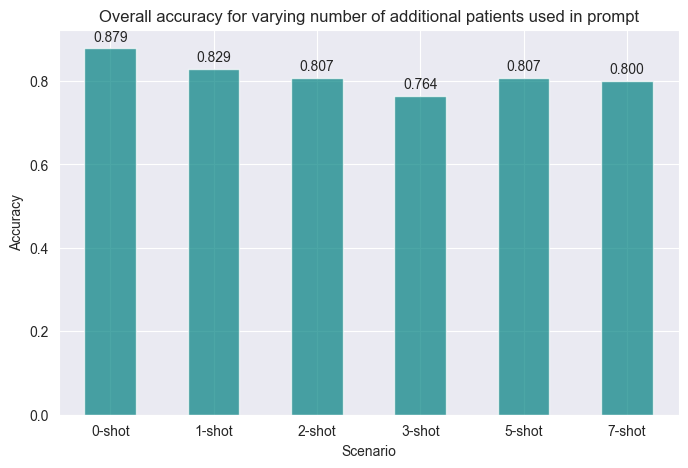

C:\Users\gjm31\AppData\Local\Temp\ipykernel_27068\2166322085.py:55: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()  # Ensure tight layout to prevent title and labels from overlapping


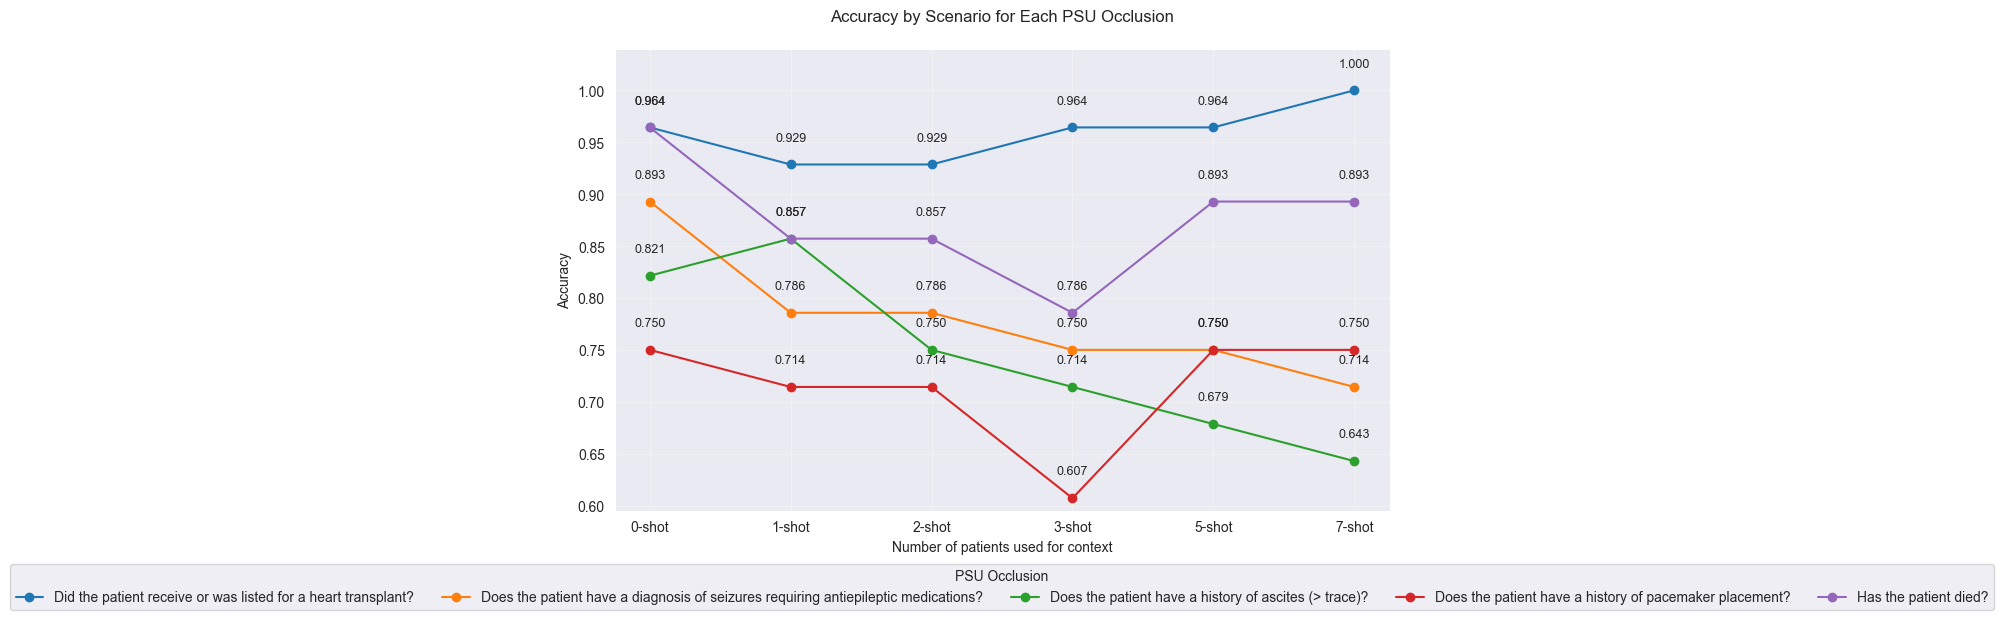

In [12]:
# Compute accuracy
df = df.rename({'human_assessment0': "0-shot", 'human_assessment1': "1-shot", 'human_assessment2': "2-shot", 
                'human_assessment3': "3-shot",  'human_assessment5': "5-shot", 'human_assessment7': "7-shot"}, axis=1)
overall_accuracy = df[['0-shot', '1-shot', '2-shot', '3-shot',  '5-shot', '7-shot']].mean()
accuracy_by_psu = df.groupby('psu_occlusion')[['0-shot', '1-shot', '2-shot', '3-shot',  '5-shot', '7-shot']].mean()

# df = df.rename({'human_assessment0': "0-shot", 'human_assessment1': "1-shot", 'human_assessment2': "2-shot", 
#                 'human_assessment3': "3-shot"}, axis=1)
# overall_accuracy = df[['1-shot', '2-shot', '3-shot']].mean()
# accuracy_by_psu = df.groupby('psu_occlusion')[['1-shot', '2-shot', '3-shot']].mean()

# Plot overall accuracy with labels above bars
plt.figure(figsize=(8, 5))
bars = overall_accuracy.plot(kind='bar', color='teal', alpha=0.7)
plt.title('Overall accuracy for varying number of additional patients used in prompt')
plt.ylabel('Accuracy')
plt.xlabel('Scenario')
plt.xticks(rotation=0)

# Add labels above bars
for bar in bars.patches:
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        bar.get_height() + 0.01, 
        f'{bar.get_height():.3f}', 
        ha='center', 
        va='bottom',
        fontsize=10
    )
plt.show()

# Plot accuracy by psu_occlusion with labels at each dot
fig, ax = plt.subplots(figsize=(10, 6))
for psu in accuracy_by_psu.index:
    accuracies = accuracy_by_psu.loc[psu]
    ax.plot(accuracies.index, accuracies.values, marker='o', label=f'{psu}')

    # Add labels to each dot with adjusted vertical spacing
    for x, y in zip(accuracies.index, accuracies.values):
        ax.text(x, y + 0.02, f'{y:.3f}', ha='center', va='bottom', fontsize=9)

# Plot configuration
ax.set_title('Accuracy by Scenario for Each PSU Occlusion', pad=20)  # Add padding to the title
ax.set_ylabel('Accuracy')
ax.set_xlabel('Number of patients used for context')
ax.set_xticks(range(len(overall_accuracy.index)))
ax.set_xticklabels(overall_accuracy.index, rotation=0)

# Adjust legend placement to avoid covering lines
ax.legend(title='PSU Occlusion', loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=len(accuracy_by_psu.index))

# Increase vertical space above and below the plot
ax.set_ylim(0.595, 1.04)  # Extend y-axis to make space for text
ax.grid(alpha=0.3)
plt.tight_layout()  # Ensure tight layout to prevent title and labels from overlapping

plt.show()


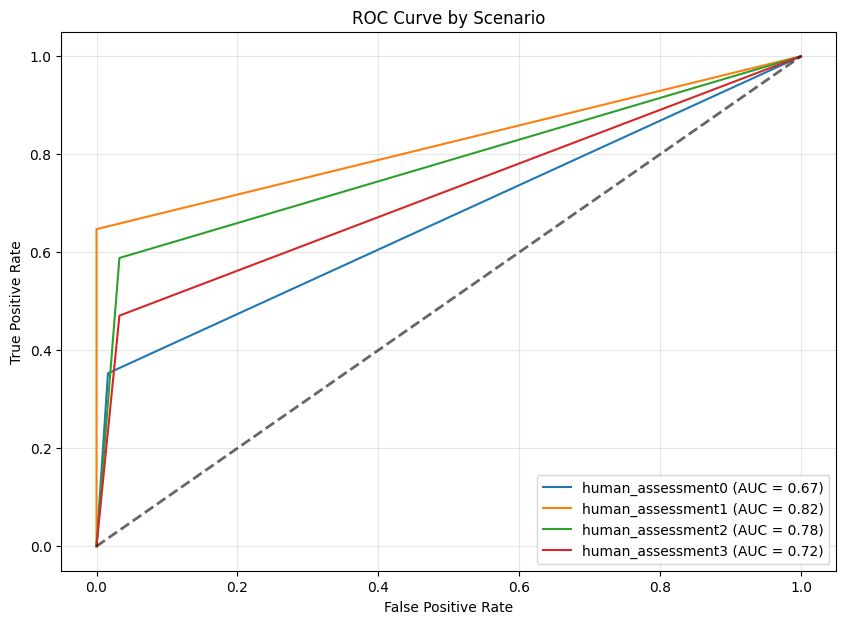

In [44]:
# Columns for models
scenarios = ['human_assessment0', 'human_assessment1', 'human_assessment2', 'human_assessment3']

# Initialize plot
plt.figure(figsize=(10, 7))

# Loop through scenarios
for scenario in scenarios:
    fpr, tpr, _ = roc_curve(df['yesno_gt'], df[scenario].apply(lambda x: np.mod(x+1, 2)))
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{scenario} (AUC = {roc_auc:.2f})')

# Plot configuration
plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.6)  # Diagonal line
plt.title('ROC Curve by Scenario')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

C:\Users\gjm31\AppData\Local\Temp\ipykernel_86124\3869264564.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy = grouped.apply(lambda x: (x[col] == x['yesno_gt']).mean())
C:\Users\gjm31\AppData\Local\Temp\ipykernel_86124\3869264564.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy = grouped.apply(lambda x: (x[col] == x['yesno_gt']).mean())
C:\Users\gjm31\AppData\Local\Temp\ipykernel_

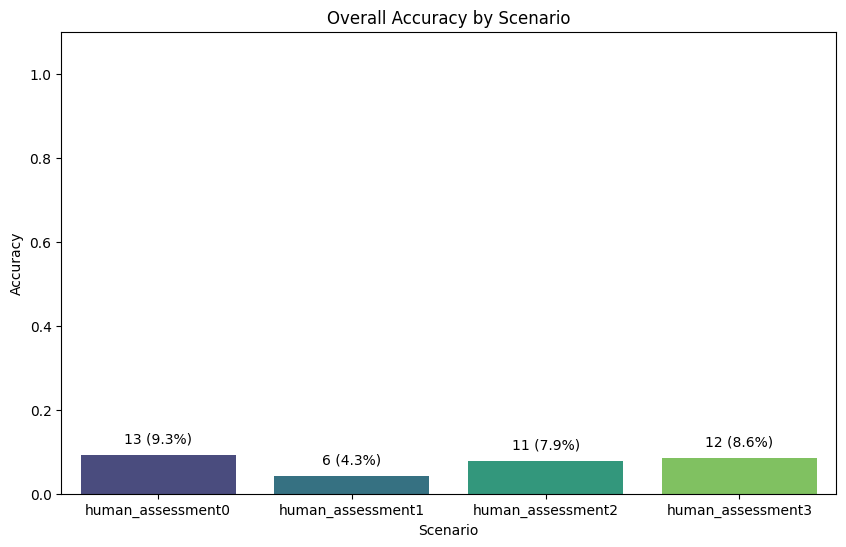

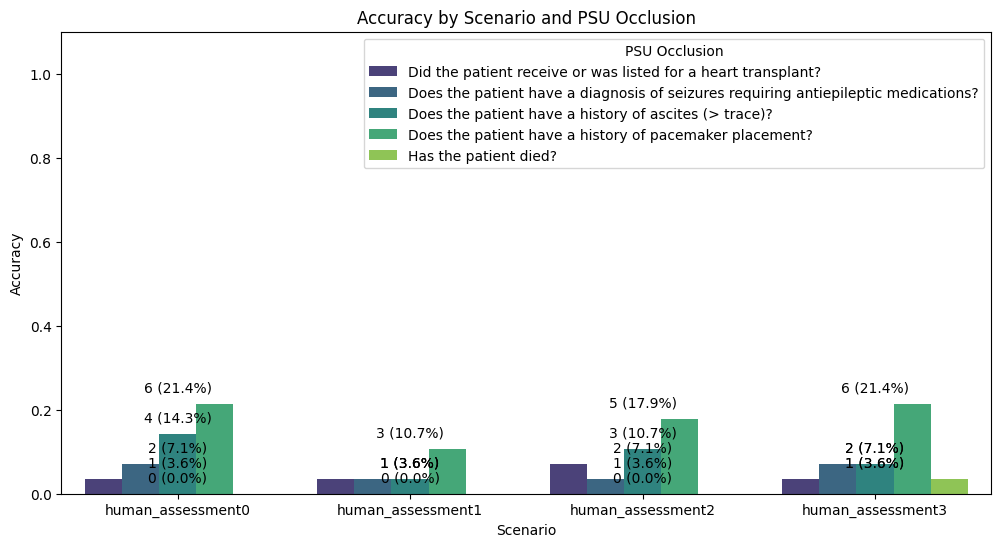

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score
# Accuracy Calculation
def calculate_accuracy_with_totals(df, columns, group_col=None):
    results = []
    for col in columns:
        if group_col:
            grouped = df.groupby(group_col)
            accuracy = grouped.apply(lambda x: (x[col] == x['yesno_gt']).mean())
            counts = grouped.size()
            for group, acc in accuracy.items():
                results.append({
                    'Scenario': col,
                    group_col: group,
                    'Accuracy': acc,
                    'Total': counts[group],
                    'Correct': int(acc * counts[group]),
                })
        else:
            acc = (df[col] == df['yesno_gt']).mean()
            total = len(df)
            correct = int(acc * total)
            results.append({'Scenario': col, 'Accuracy': acc, 'Total': total, 'Correct': correct})
    return pd.DataFrame(results)

# Calculate accuracy overall and by psu_occlusion
assessment_cols = ['human_assessment0', 'human_assessment1', 'human_assessment2', 'human_assessment3']
accuracy_overall = calculate_accuracy_with_totals(df, assessment_cols)
accuracy_by_psu = calculate_accuracy_with_totals(df, assessment_cols, group_col='psu_occlusion')

# Plot Overall Accuracy
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=accuracy_overall, x='Scenario', y='Accuracy', palette='viridis')
for index, row in accuracy_overall.iterrows():
    # Display total and percentage above bars
    ax.text(
        index, 
        row['Accuracy'] + 0.02, 
        f"{row['Correct']} ({row['Correct'] / row['Total'] * 100:.1f}%)", 
        ha='center', 
        va='bottom', 
        fontsize=10
    )
plt.title('Overall Accuracy by Scenario')
plt.ylabel('Accuracy')
plt.xlabel('Scenario')
plt.ylim(0, 1.1)
plt.show()

# Plot Accuracy by psu_occlusion
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=accuracy_by_psu, x='Scenario', y='Accuracy', hue='psu_occlusion', palette='viridis')
for index, row in accuracy_by_psu.iterrows():
    xpos = assessment_cols.index(row['Scenario'])  # Align text for grouped barplot
    ax.text(
        xpos, 
        row['Accuracy'] + 0.02, 
        f"{row['Correct']} ({row['Correct'] / row['Total'] * 100:.1f}%)", 
        ha='center', 
        va='bottom', 
        fontsize=10
    )
plt.title('Accuracy by Scenario and PSU Occlusion')
plt.ylabel('Accuracy')
plt.xlabel('Scenario')
plt.ylim(0, 1.1)
plt.legend(title='PSU Occlusion')
plt.show()


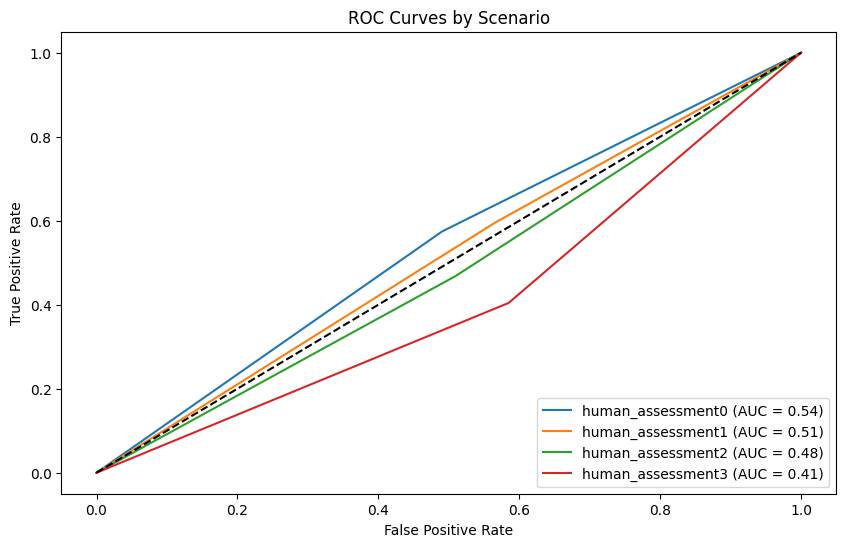

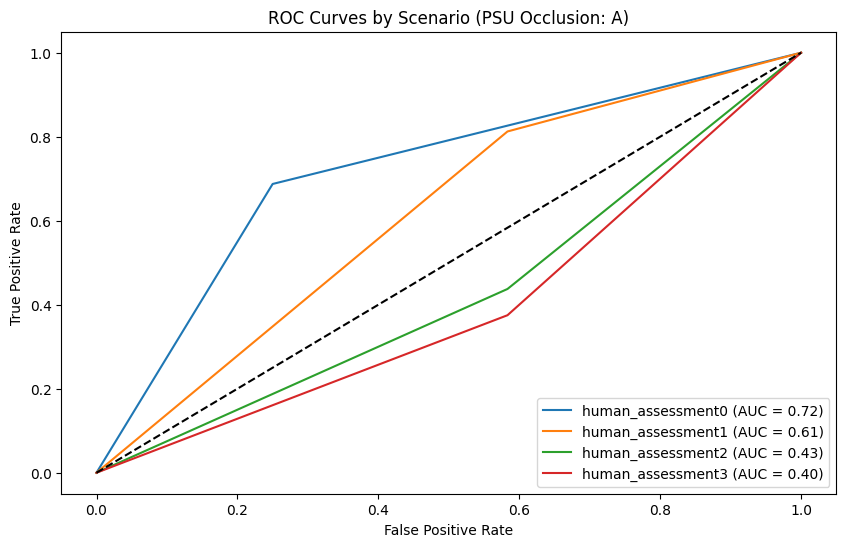

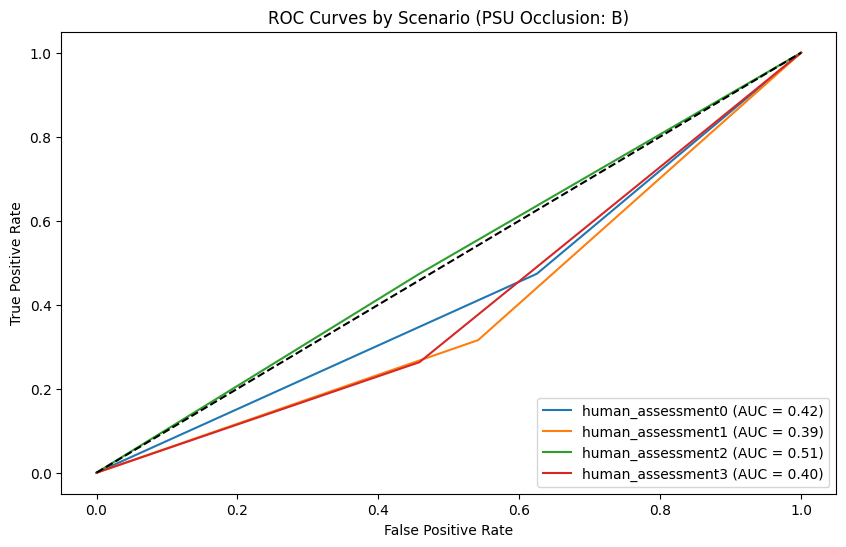

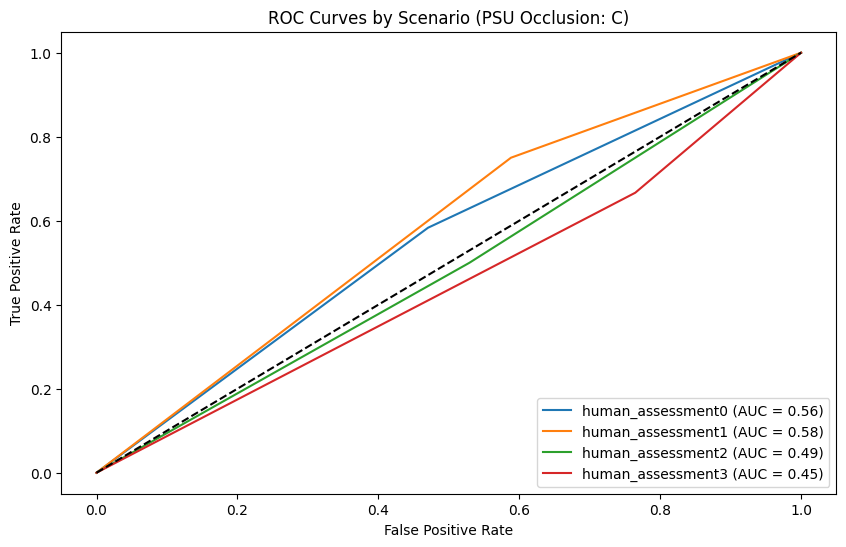

In [11]:
# ROC Curve and AUC
def plot_roc_curves(df, columns, group_col=None):
    if group_col:
        grouped = df.groupby(group_col)
        for group, group_df in grouped:
            plt.figure(figsize=(10, 6))
            for col in columns:
                fpr, tpr, _ = roc_curve(group_df['yesno_gt'], group_df[col])
                auc = roc_auc_score(group_df['yesno_gt'], group_df[col])
                plt.plot(fpr, tpr, label=f'{col} (AUC = {auc:.2f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.title(f'ROC Curves by Scenario (PSU Occlusion: {group})')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.legend(loc='lower right')
            plt.show()
    else:
        plt.figure(figsize=(10, 6))
        for col in columns:
            fpr, tpr, _ = roc_curve(df['yesno_gt'], df[col])
            auc = roc_auc_score(df['yesno_gt'], df[col])
            plt.plot(fpr, tpr, label=f'{col} (AUC = {auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title('ROC Curves by Scenario')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()

# Plot overall ROC curves
plot_roc_curves(df, assessment_cols)

# Plot ROC curves by psu_occlusion
plot_roc_curves(df, assessment_cols, group_col='psu_occlusion')